In [14]:
%load_ext autoreload

%autoreload 2

from funkce import *
    
import matplotlib.pyplot as plt

from ipyparallel import Client

cluster = Client()
lb_view = cluster.load_balanced_view()

print("Profile: %s" % cluster.profile)
print("Engines: %s" % len(lb_view))

%px from funkce import *

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Profile: default
Engines: 8


In [9]:
##Musím definovat funkci pro FF, kde lze zadávat 2 různé permitivity... tato verze jen pro isotropní případ

def get_Q_matrix(perm1,perm2, period, n_terms, fill_factor):
    
    def q_11_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return perm1[0,0] * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return perm2[0,0] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_11 = get_C_matrix(period, q_11_integral, n_terms)
    
    def q_33_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return perm1[2,2] * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return perm2[2,2] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_33 = get_C_matrix(period, q_33_integral, n_terms)

    def q_22_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 1 / perm1[1,1] * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return 1 / perm2[1,1] * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    q_22 = get_C_matrix(period, q_22_integral, n_terms) ** -1
    
    def q_0_integral(x):
        def integrand_function(y):
            if (y < (1 - fill_factor) * period):
                return 0 * np.exp(-1j * x * 2 * np.pi / period * y)
            elif (y < period):
                return 0 * np.exp(-1j * x * 2 * np.pi / period * y)

        return 1 / period * (complex_quadrature(integrand_function, 0, period, 100))

    
    q_0 = get_C_matrix(period, q_0_integral, n_terms)
    
    return q_11,q_0, q_0, q_0, q_22, q_0, q_0,q_0, q_33

# Definování struktury

In [10]:
n_air = 1
n_0 = 1.5
n_1 = 1 - 6j

width_incoherent = 2000
width_1 = 20
width_2 = 80
width_3 = 20

angle = 0
n_terms = 20
period = 1000
fill_factor = 0.5

perm_0 = np.array([[n_0**2,0,0],[0,n_0**2,0],[0,0,n_0**2]])
perm_1 = np.array([[n_1**2,0,0],[0,n_1**2,0],[0,0,n_1**2]])
perm_air = np.array([[1,0,0],[0,1,0],[0,0,1]])

#calculate localy just once
q_incoherent = get_Q_matrix(perm_0,perm_0,period,n_terms,1)
q_1 = get_Q_matrix(perm_0,perm_1,period,n_terms,fill_factor)
q_2 = get_Q_matrix(perm_0,perm_0,period,n_terms,fill_factor)
q_3 = get_Q_matrix(perm_1,perm_0,period,n_terms,fill_factor)

points = np.linspace(400,800,400)

#Push result to every cluster
cluster[:].push({'q_incoherent': q_incoherent, 'q_1': q_1, 'q_2': q_2, 'q_3': q_3})


<AsyncResult: _push>

In [11]:
%%px 

#Define variables at all clusters
n_air = 1
n_0 = 1.5
n_1 = 1 - 6j

width_incoherent = 2000
width_1 = 20
width_2 = 80
width_3 = 20

angle = 0
n_terms = 20
period = 1000
fill_factor = 0.5

perm_0 = np.array([[n_0**2,0,0],[0,n_0**2,0],[0,0,n_0**2]])
perm_1 = np.array([[n_1**2,0,0],[0,n_1**2,0],[0,0,n_1**2]])
perm_air = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Grating without the thick capping layer

In [12]:
#Define the function - without thick capping layer
def wvDep(wv):
    t0 = get_outer_T(n_terms,n_air,angle,wv,period,n_air)
    #t_incoherent,p_incoherent = get_periodic_layer_T_P_aniso(period,q_incoherent[0],q_incoherent[1],q_incoherent[2],q_incoherent[3],q_incoherent[4],q_incoherent[5],q_incoherent[6],q_incoherent[7],q_incoherent[8],n_terms,angle,0,wv,n_air,width_incoherent)
    t1,p1 = get_periodic_layer_T_P_aniso(period,q_1[0],q_1[1],q_1[2],q_1[3],q_1[4],q_1[5],q_1[6],q_1[7],q_1[8],n_terms,angle,0,wv,n_air,width_1)
    t2,p2 = get_periodic_layer_T_P_aniso(period,q_2[0],q_2[1],q_2[2],q_2[3],q_2[4],q_2[5],q_2[6],q_2[7],q_2[8],n_terms,angle,0,wv,n_air,width_2)
    t3,p3 = get_periodic_layer_T_P_aniso(period,q_3[0],q_3[1],q_3[2],q_3[3],q_3[4],q_3[5],q_3[6],q_3[7],q_3[8],n_terms,angle,0,wv,n_air,width_3)
    t4 = get_outer_T(n_terms,n_0,angle,wv,period,n_air)

    #s_0 = get_s(t0,t_incoherent,p_incoherent)
    s_1 = get_s(t0,t1,p1)
    s_2 = get_s(t1,t2,p2)
    s_3 = get_s(t2,t3,p3)
    s_boundary = get_s_boundary(t3,t4)
    
    #s = join_s_matrices_recur(s_0,s_1)
    s = join_s_matrices_recur(s_1,s_2)
    s = join_s_matrices_recur(s,s_3)
    T_uu,R_ud,R_du,T_dd = join_s_matrices(s,s_boundary)

    Rs_order0 = np.abs(R_ud[n_terms,n_terms])**2*diff_eff_coef(0,angle,n_air,wv,period)
    Rp_order0 = np.abs(R_ud[3*n_terms+1,3*n_terms+1])**2*diff_eff_coef(0,angle,n_air,wv,period)
    
    Rs_order_neg1 = np.abs(R_ud[n_terms-1,n_terms])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rs_order_neg2 = np.abs(R_ud[n_terms-2,n_terms])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rs_order_neg3 = np.abs(R_ud[n_terms-3,n_terms])**2*diff_eff_coef(-3,angle,n_air,wv,period)
    
    Rs_order_pos1 = np.abs(R_ud[n_terms+1,n_terms])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rs_order_pos2 = np.abs(R_ud[n_terms+2,n_terms])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rs_order_pos3 = np.abs(R_ud[n_terms+3,n_terms])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    Rp_order_neg1 = np.abs(R_ud[3*n_terms,3*n_terms+1])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rp_order_neg2 = np.abs(R_ud[3*n_terms-1,3*n_terms+1])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rp_order_neg3 = np.abs(R_ud[3*n_terms-2,3*n_terms+1])**2*diff_eff_coef(-3,angle,n_air,wv,period)

    Rp_order_pos1 = np.abs(R_ud[3*n_terms+2,3*n_terms+1])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rp_order_pos2 = np.abs(R_ud[3*n_terms+3,3*n_terms+1])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rp_order_pos3 = np.abs(R_ud[3*n_terms+4,3*n_terms+1])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    return [[Rs_order0,Rs_order_neg1,Rs_order_neg2,Rs_order_neg3,Rs_order_pos1,Rs_order_pos2,Rs_order_pos3],[Rp_order0,Rp_order_neg1,Rp_order_neg2,Rp_order_neg3,Rp_order_pos1,Rp_order_pos2,Rp_order_pos3]] 

<IPython.core.display.Javascript object>


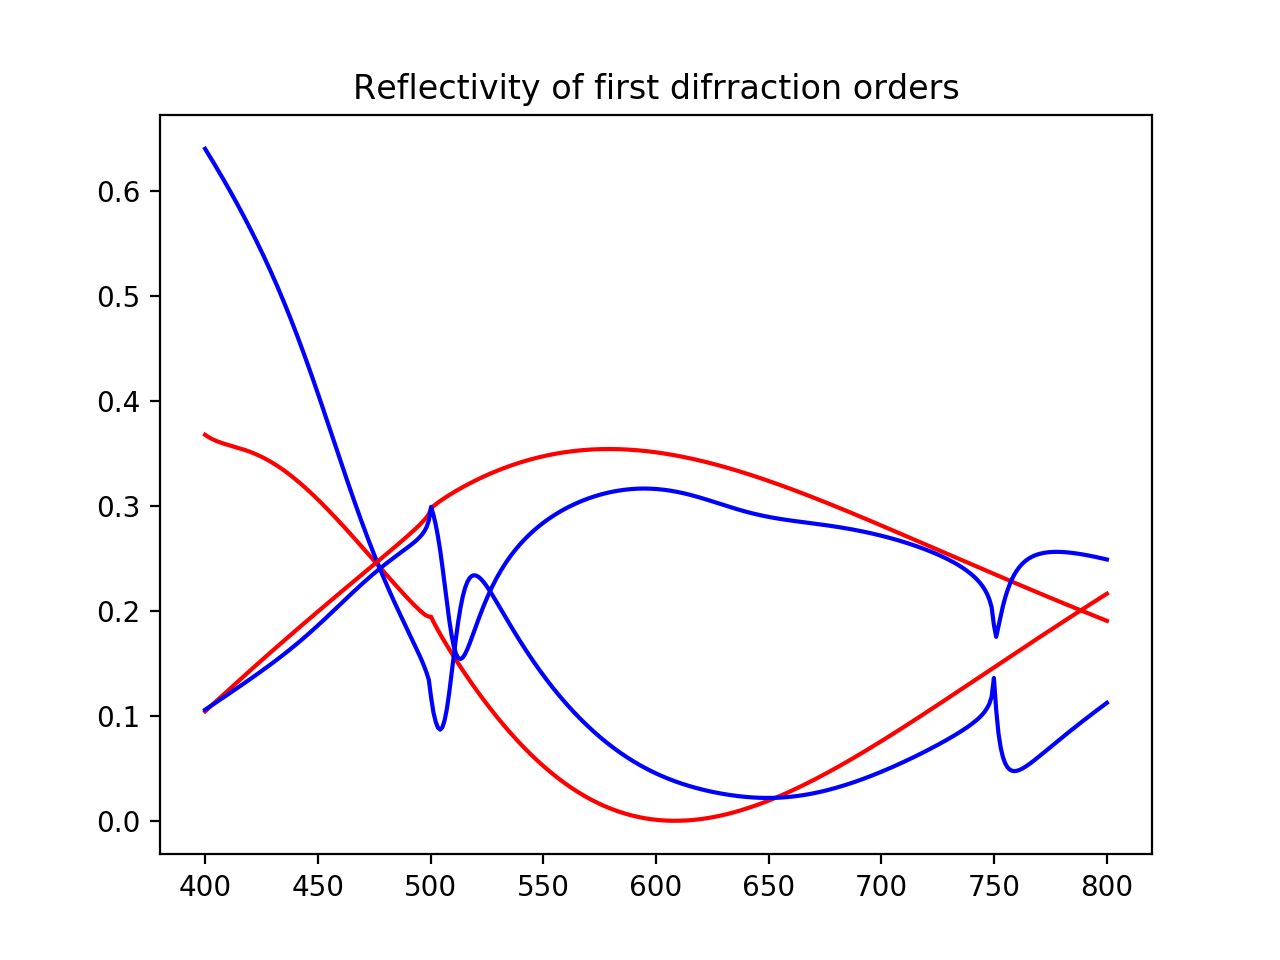

CPU times: user 4.89 s, sys: 1.57 s, total: 6.46 s
Wall time: 1min 9s


In [15]:
%%time

values = np.array(lb_view.map_sync(wvDep,points))

specular = (values[:,0,0]+values[:,1,0])/2
diffraction = (values[:,0,1]+values[:,1,1] + values[:,0,4]+values[:,1,4])/4
plt.title("Reflectivity of zero difrraction order")
plt.plot(points,values[:,0,0],'r-', points, values[:,1,0], 'b-')
plt.show()

plt.title("Reflectivity of first difrraction orders")
plt.plot(points,values[:,0,1],'r-',points,values[:,1,1],'b-')
plt.show()

# Model with thick capping layer

In [5]:
#Define the function
def wvDep(wv):
    t0 = get_outer_T(n_terms,n_air,angle,wv,period,n_air)
    t_incoherent,p_incoherent = get_periodic_layer_T_P_aniso(period,q_incoherent[0],q_incoherent[1],q_incoherent[2],q_incoherent[3],q_incoherent[4],q_incoherent[5],q_incoherent[6],q_incoherent[7],q_incoherent[8],n_terms,angle,0,wv,n_air,width_incoherent)
    t1,p1 = get_periodic_layer_T_P_aniso(period,q_1[0],q_1[1],q_1[2],q_1[3],q_1[4],q_1[5],q_1[6],q_1[7],q_1[8],n_terms,angle,0,wv,n_air,width_1)
    t2,p2 = get_periodic_layer_T_P_aniso(period,q_2[0],q_2[1],q_2[2],q_2[3],q_2[4],q_2[5],q_2[6],q_2[7],q_2[8],n_terms,angle,0,wv,n_air,width_2)
    t3,p3 = get_periodic_layer_T_P_aniso(period,q_3[0],q_3[1],q_3[2],q_3[3],q_3[4],q_3[5],q_3[6],q_3[7],q_3[8],n_terms,angle,0,wv,n_air,width_3)
    t4 = get_outer_T(n_terms,n_0,angle,wv,period,n_air)

    s_0 = get_s(t0,t_incoherent,p_incoherent)
    s_1 = get_s(t_incoherent,t1,p1)
    s_2 = get_s(t1,t2,p2)
    s_3 = get_s(t2,t3,p3)
    s_boundary = get_s_boundary(t3,t4)
    
    s = join_s_matrices_recur(s_0,s_1)
    s = join_s_matrices_recur(s,s_2)
    s = join_s_matrices_recur(s,s_3)
    T_uu,R_ud,R_du,T_dd = join_s_matrices(s,s_boundary)

    Rs_order0 = np.abs(R_ud[n_terms,n_terms])**2*diff_eff_coef(0,angle,n_air,wv,period)
    Rp_order0 = np.abs(R_ud[3*n_terms+1,3*n_terms+1])**2*diff_eff_coef(0,angle,n_air,wv,period)
    
    Rs_order_neg1 = np.abs(R_ud[n_terms-1,n_terms])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rs_order_neg2 = np.abs(R_ud[n_terms-2,n_terms])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rs_order_neg3 = np.abs(R_ud[n_terms-3,n_terms])**2*diff_eff_coef(-3,angle,n_air,wv,period)
    
    Rs_order_pos1 = np.abs(R_ud[n_terms+1,n_terms])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rs_order_pos2 = np.abs(R_ud[n_terms+2,n_terms])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rs_order_pos3 = np.abs(R_ud[n_terms+3,n_terms])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    Rp_order_neg1 = np.abs(R_ud[3*n_terms,3*n_terms+1])**2*diff_eff_coef(-1,angle,n_air,wv,period)
    Rp_order_neg2 = np.abs(R_ud[3*n_terms-1,3*n_terms+1])**2*diff_eff_coef(-2,angle,n_air,wv,period)
    Rp_order_neg3 = np.abs(R_ud[3*n_terms-2,3*n_terms+1])**2*diff_eff_coef(-3,angle,n_air,wv,period)

    Rp_order_pos1 = np.abs(R_ud[3*n_terms+2,3*n_terms+1])**2*diff_eff_coef(1,angle,n_air,wv,period)
    Rp_order_pos2 = np.abs(R_ud[3*n_terms+3,3*n_terms+1])**2*diff_eff_coef(2,angle,n_air,wv,period)
    Rp_order_pos3 = np.abs(R_ud[3*n_terms+4,3*n_terms+1])**2*diff_eff_coef(3,angle,n_air,wv,period)
    
    return [[Rs_order0,Rs_order_neg1,Rs_order_neg2,Rs_order_neg3,Rs_order_pos1,Rs_order_pos2,Rs_order_pos3],[Rp_order0,Rp_order_neg1,Rp_order_neg2,Rp_order_neg3,Rp_order_pos1,Rp_order_pos2,Rp_order_pos3]] 

# Coherent case - big interference

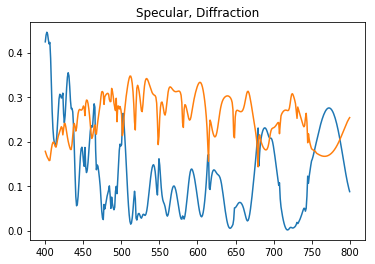

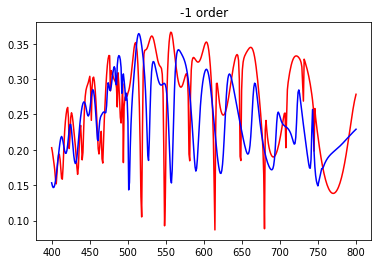

CPU times: user 1.66 s, sys: 223 ms, total: 1.89 s
Wall time: 1min 19s


In [6]:
%%time

values = np.array(lb_view.map_sync(wvDep,points))

specular = (values[:,0,0]+values[:,1,0])/2
diffraction = (values[:,0,1]+values[:,1,1] + values[:,0,4]+values[:,1,4])/4
plt.title("Specular, Diffraction")
plt.plot(points,specular, points, diffraction)
plt.show()

plt.title("-1 order")
plt.plot(points,values[:,0,1],'r-',points,values[:,1,1],'b-')
plt.show()

# Partial coherence - averaging over width

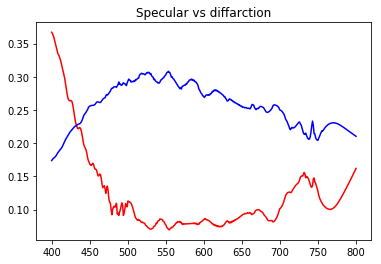

CPU times: user 30 s, sys: 4.34 s, total: 34.4 s
Wall time: 26min 21s


In [7]:
%%time

def average_width(width_incoherent):
    cluster[:].push({'width_incoherent': width_incoherent})
    values = np.array(lb_view.map_sync(wvDep,points))
    specular = (values[:,0,0]+values[:,1,0])/2
    diffraction = (values[:,0,1]+values[:,1,1] + values[:,0,4]+values[:,1,4])/4
    return specular,diffraction

#Area to average over
n_points = 20
width = np.linspace(1800,2200,n_points)
result = np.array(list(map(average_width,width)))

specular_mean = result[:,0].mean(axis=0)
diffraction_mean = result[:,1].mean(axis=0)

plt.title("Specular vs diffarction")
plt.plot(points,specular_mean,'r-',points,diffraction_mean,'b-')
plt.show()

# Incoherent case - coherence matrix approach

/Users/premyslciompa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


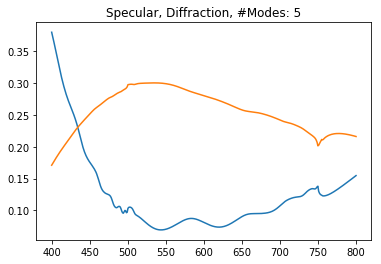

CPU times: user 8min 55s, sys: 8.47 s, total: 9min 4s
Wall time: 3min 41s


In [8]:
%%time

#Define the function
def wvDep(wv):
    t0 = get_outer_T(n_terms,n_air,angle,wv,period,n_air)
    t_incoherent = get_outer_T(n_terms,n_0,angle,wv,period,n_air)
    
    t1,p1 = get_periodic_layer_T_P_aniso(period,q_1[0],q_1[1],q_1[2],q_1[3],q_1[4],q_1[5],q_1[6],q_1[7],q_1[8],n_terms,angle,0,wv,n_air,width_1)
    t2,p2 = get_periodic_layer_T_P_aniso(period,q_2[0],q_2[1],q_2[2],q_2[3],q_2[4],q_2[5],q_2[6],q_2[7],q_2[8],n_terms,angle,0,wv,n_air,width_2)
    t3,p3 = get_periodic_layer_T_P_aniso(period,q_3[0],q_3[1],q_3[2],q_3[3],q_3[4],q_3[5],q_3[6],q_3[7],q_3[8],n_terms,angle,0,wv,n_air,width_3)
    t4 = get_outer_T(n_terms,n_0,angle,wv,period,n_air)
 
    s_0 = get_s_boundary(t0,t_incoherent)
    T_uu,R_ud,R_du,T_dd = split_matrix(s_0)
    r_01,t_01,r_10,t_10 = select_modes(n_terms,n_select,R_ud),select_modes(n_terms,n_select,T_dd),select_modes(n_terms,n_select,R_du),select_modes(n_terms,n_select,T_uu)
    
    s_1 = get_s(t_incoherent,t1,p1)
    s_2 = get_s(t1,t2,p2)
    s_3 = get_s(t2,t3,p3)
    s_boundary = get_s_boundary(t3,t4)
    
    s = join_s_matrices_recur(s_1,s_2)
    s = join_s_matrices_recur(s,s_3)
    T_uu,R_ud,R_du,T_dd = join_s_matrices(s,s_boundary)
    r_12,t_12 = select_modes(n_terms,n_select,R_ud),select_modes(n_terms,n_select,T_dd)
    
    a = prop_trans(n_select)
    
    #Propagační matice pro každý mód
    p_13 = get_prop_matrix(period,angle,n_0,n_air,n_select,width_incoherent,wv)
    p_24 = get_prop_matrix(period,angle,n_0,n_air,n_select,width_incoherent,wv)
        
    #Tvorba koherenčních matic
    cr_01 = np.kron(r_01,np.conj(r_01))
    ct_01 = np.kron(t_01,np.conj(t_01))
    cr_10 = np.kron(r_10,np.conj(r_10))
    ct_10 = np.kron(t_10,np.conj(t_10))
    cr_12 = np.kron(r_12,np.conj(r_12))
    ct_12 = np.kron(t_12,np.conj(t_12))
    cp_13 = np.kron(p_13,np.conj(p_13))
    cp_24 = np.kron(p_24,np.conj(p_24))
    
    coh_reflektance = cr_01 + ct_10*cp_24*cr_12*cp_13*(np.matrix(np.identity((2*(2*n_select+1))**2)) - cr_10*cp_24*cr_12*cp_13)**-1*ct_01
    
    order = 0
    coh_matrix_0 = get_order_coh_matrix(coh_reflektance,n_select,order)*diff_eff_coef(order,angle,n_air,wv,period)
    order = 1
    coh_matrix_1 = get_order_coh_matrix(coh_reflektance,n_select,order)*diff_eff_coef(order,angle,n_air,wv,period)
    order = -1
    coh_matrix_m1 = get_order_coh_matrix(coh_reflektance,n_select,order)*diff_eff_coef(order,angle,n_air,wv,period)
    
    specular = (coh_matrix_0[0,0] + coh_matrix_0[3,3])/2
    diffraction = (coh_matrix_1[0,0] + coh_matrix_1[3,3] + coh_matrix_m1[0,0] + coh_matrix_m1[3,3])/4
    
    return specular, diffraction

n_select = 5
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()

# Konvergence s počtem přidaných módů 

/Users/premyslciompa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


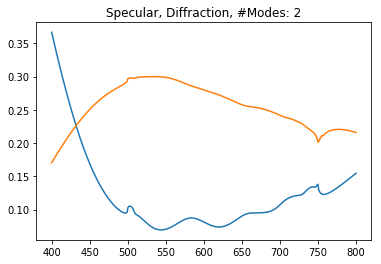

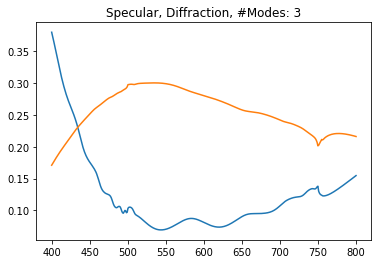

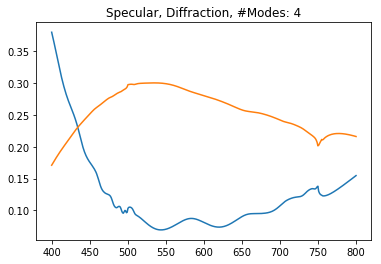

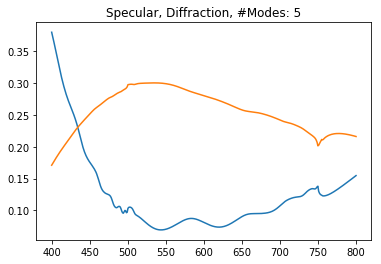

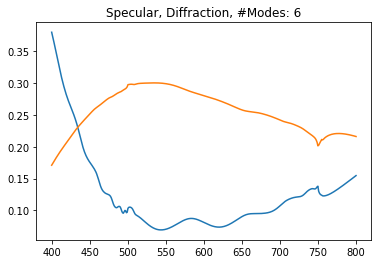

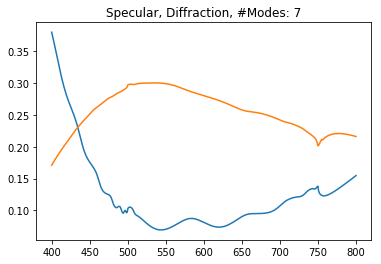

In [9]:

n_select = 2
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()

n_select = 3
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()

n_select = 4
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()

n_select = 5
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()


n_select = 6
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()

n_select = 7
values = np.array(list(map(wvDep,points)))

plt.title("Specular, Diffraction, #Modes: %i" %n_select)
plt.plot(points,values[:,0], points, values[:,1])
plt.show()